In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load your data (replace 'data.csv' with your file)
data = pd.read_csv('/content/crop_dataset_cleaned.csv')

# Filter for bajra crop
bajra_data = data[data['crop'] == 'bajra'].copy()

# Convert 'year' to numeric start year (e.g., '2011 - 2012' -> 2011)
bajra_data['year_num'] = bajra_data['year'].str[:4].astype(int)

# Example: Select one district for demonstration
district = 'Bagalkot'
district_data = bajra_data[bajra_data['district_name'] == district].sort_values('year_num')

# Set year as index
district_data.set_index('year_num', inplace=True)

# Extract time series for area and production
area_ts = district_data['area']
production_ts = district_data['production']


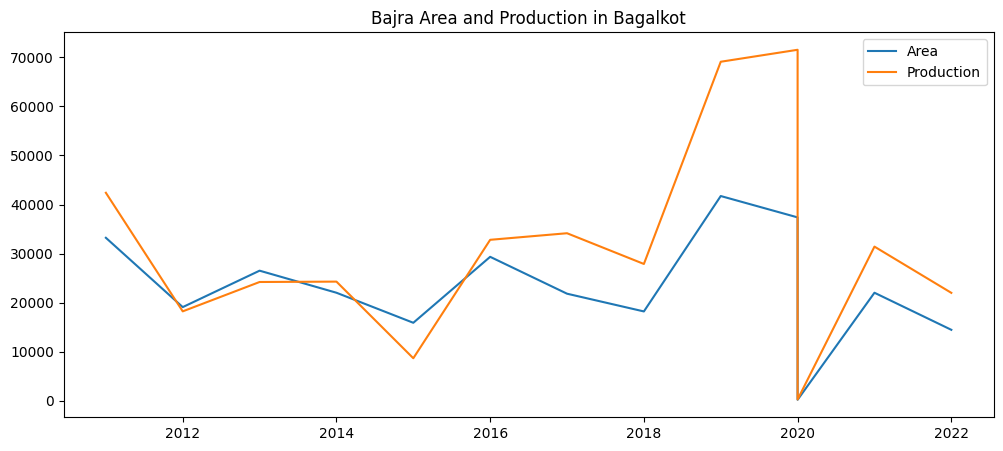

Augmented Dickey-Fuller Test: Area
ADF Statistic : -2.241152629366532
p-value : 0.19164975226014808
# Lags Used : 4
Number of Observations Used : 8
Weak evidence against null hypothesis (series is non-stationary)
Augmented Dickey-Fuller Test: Production
ADF Statistic : -2.2800357600551213
p-value : 0.17848769655301672
# Lags Used : 4
Number of Observations Used : 8
Weak evidence against null hypothesis (series is non-stationary)


In [3]:
# Plot area and production time series
plt.figure(figsize=(12,5))
plt.plot(area_ts, label='Area')
plt.plot(production_ts, label='Production')
plt.title(f'Bajra Area and Production in {district}')
plt.legend()
plt.show()

# Augmented Dickey-Fuller test for stationarity
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (series is stationary)")
    else:
        print("Weak evidence against null hypothesis (series is non-stationary)")

adf_test(area_ts, 'Area')
adf_test(production_ts, 'Production')


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

                               SARIMAX Results                                
Dep. Variable:                   area   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -130.184
Date:                Sun, 21 Sep 2025   AIC                            266.367
Time:                        12:36:27   BIC                            267.822
Sample:                             0   HQIC                           265.829
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0795      0.985     -0.081      0.936      -2.010       1.851
ma.L1         -0.8434      0.551     -1.530      0.126      -1.924       0.237
sigma2      2.264e+08   9.86e-10    2.3e+17      0.0

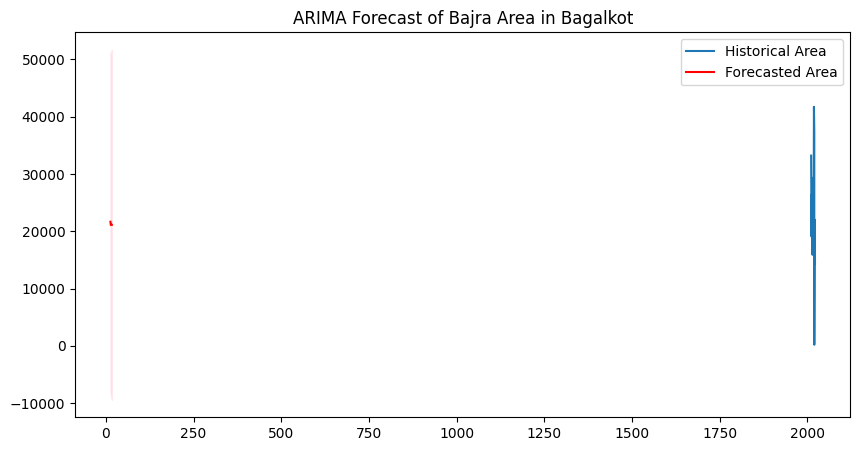

In [4]:
# Differencing if non-stationary (example for area)
area_diff = area_ts.diff().dropna()

# Fit ARIMA model (auto_arima can be used from pmdarima for parameter tuning)
model_area = ARIMA(area_ts, order=(1,1,1))  # Example order, tune as needed
model_area_fit = model_area.fit()
print(model_area_fit.summary())

# Forecast next 5 years
area_forecast = model_area_fit.get_forecast(steps=5)
area_pred = area_forecast.predicted_mean
area_conf_int = area_forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(area_ts, label='Historical Area')
plt.plot(area_pred.index, area_pred, label='Forecasted Area', color='red')
plt.fill_between(area_conf_int.index, area_conf_int.iloc[:,0], area_conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title(f'ARIMA Forecast of Bajra Area in {district}')
plt.legend()
plt.show()


The model residuals look well-behaved (no autocorrelation, roughly normal), which means the model fits the data reasonably in terms of error structure.
However, the AR and MA coefficients are not statistically significant, suggesting the model may not be capturing meaningful temporal patterns in the differenced area data.
The large residual variance indicates the data is quite noisy or variable.
The small sample size (13 observations) limits the power to detect significant effects and may cause unstable estimates.
The borderline heteroskedasticity suggests the variance of errors might change over time, which ARIMA models do not handle well.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.2367 - val_loss: 0.1121
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2965 - val_loss: 0.0947
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3005 - val_loss: 0.0780
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1465 - val_loss: 0.0640
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2537 - val_loss: 0.0484
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1213 - val_loss: 0.0370
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1575 - val_loss: 0.0255
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1863 - val_loss: 0.0152
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1387 - val_loss: 0.0080
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0824 - val_loss: 0.0040
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0676 - val_loss: 0.0017
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0641 - val_loss: 0.0

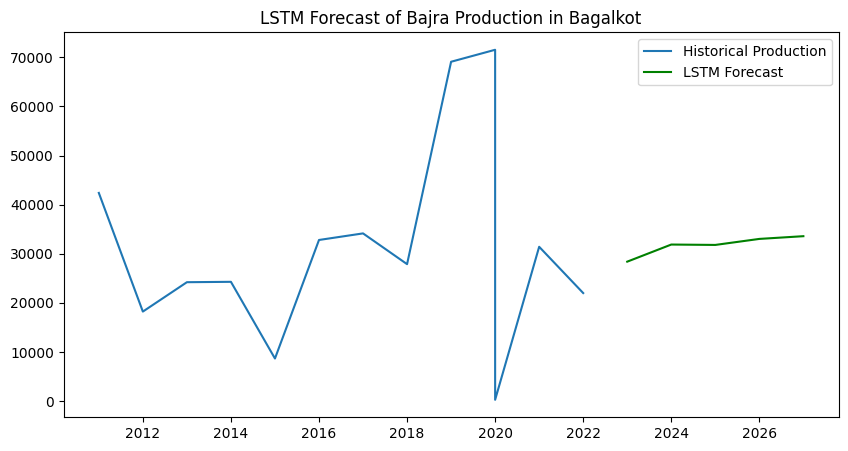

In [5]:
# Prepare data for LSTM (using production as example)
series = production_ts.values.reshape(-1,1)

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
series_scaled = scaler.fit_transform(series)

# Create sequences for supervised learning
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(series_scaled, seq_length)

# Split into train and test sets (e.g., 80% train)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Forecast next 5 years
input_seq = series_scaled[-seq_length:].reshape(1, seq_length, 1)
predictions = []
for _ in range(5):
    pred = model.predict(input_seq)[0]
    predictions.append(pred)
    input_seq = np.append(input_seq[:,1:,:], [[pred]], axis=1)

# Inverse scale predictions
predictions = scaler.inverse_transform(predictions)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(production_ts.index, production_ts.values, label='Historical Production')
future_years = range(production_ts.index[-1]+1, production_ts.index[-1]+6)
plt.plot(future_years, predictions.flatten(), label='LSTM Forecast', color='green')
plt.title(f'LSTM Forecast of Bajra Production in {district}')
plt.legend()
plt.show()
